<a href="https://colab.research.google.com/github/ivoryRabbit/NIMS_PLIM/blob/gh-pages/3_ARIMA%26MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ARIMA based models

- ARIMA 모델 및 Seasonal ARIMA 모델을 사용하였습니다.
- 그 외에 ARIMA based는 아니지만 Prophet, MLP 모델을 사용하였습니다.
- MLP 모델의 성능이 가장 좋았습니다.
- (참고) EDA에서 4.1과 4.5를 덜 수행한채 학습했던 모델이라 약간의 점수차가 있습니다.

## Results

1. ARIMA
    - 결과: 36.03855
2. SARIMAX
    - 결과: 21.88804
3. Prophet
    - 결과: -
4. sklearn MLP
    - 결과: 19.60146

In [ ]:
import pandas as pd
import numpy as np
import glob, re, gc, os
np.random.seed(777)

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('bmh')

from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.api import OLS

from tqdm import tqdm_notebook

!pip install fbprophet
from fbprophet import Prophet

import warnings
warnings.filterwarnings('ignore')

Looking in indexes: http://mirror.kakao.com/pypi/simple
     |████████████████████████████████| 61kB 6.4MB/s eta 0:00:011
     |████████████████████████████████| 67.3MB 8.3MB/s eta 0:00:01
     |████████████████████████████████| 112kB 39.0MB/s eta 0:00:01
     |████████████████████████████████| 1.2MB 30.5MB/s eta 0:00:01
     |████████████████████████████████| 737kB 37.8MB/s eta 0:00:01
  ERROR: Complete output from command /opt/conda/bin/python -u -c 'import setuptools, tokenize;__file__='"'"'/tmp/pip-install-lglc6ku5/fbprophet/setup.py'"'"';f=getattr(tokenize, '"'"'open'"'"', open)(__file__);code=f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' bdist_wheel -d /tmp/pip-wheel-ohx9icbi --python-tag cp37:
  ERROR: running bdist_wheel
  running build
  running build_py
  creating build
  creating build/lib
  creating build/lib/fbprophet
  creating build/lib/fbprophet/stan_model
  Traceback (most recent call last):
    File "<string>",

Importing plotly failed. Interactive plots will not work.


In [ ]:
train = pd.read_csv('data/train_clean.csv', index_col = 'id')
test = pd.read_csv('data/test.csv', index_col = 'id')
sample_submission = pd.read_csv('data/sample_submission.csv', index_col = 'id')
print(train.shape, test.shape, sample_submission.shape)

(61651, 125) (10000, 113) (10000, 12)


In [ ]:
X_train = train.loc[:, '2011-06': '2018-05']
y_train = train.loc[:, '2018-06':]
X_test = test.loc[:, '2011-06':]

### 1. ARIMA

- ARIMA(Autoregressive Integrated Moving Average)는 시계열 데이터를 예측할 때 매우 유명한 모델입니다.
- 계절성을 갖고 있는 우리의 데이터에 적합하지 않습니다.
- 대회 초기에 시간을 갖고 공부했던 모델이지만 다른 모델들에게 밀려 거의 사용하지 않았습니다.

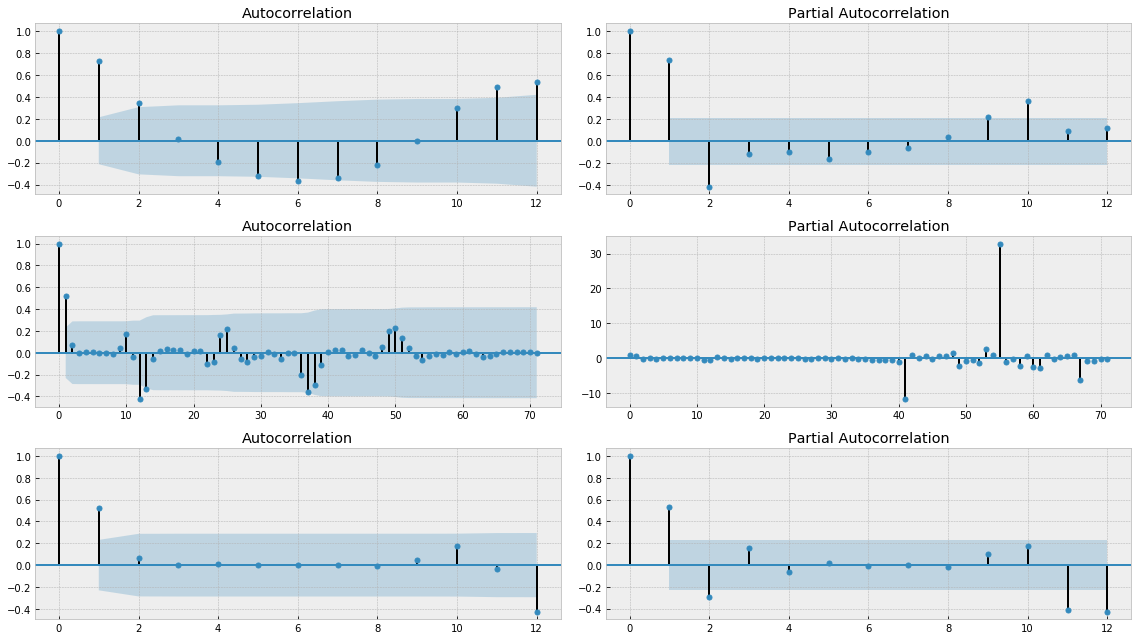

In [ ]:
fig, axes = plt.subplots(nrows = 3, ncols = 2, figsize = (16, 9))
plot_acf(X_train.iloc[0], lags = 12, ax = axes[0, 0])
plot_pacf(X_train.iloc[0], lags = 12, ax = axes[0, 1])
plot_acf(X_train.iloc[0].diff(12).dropna(), ax = axes[1, 0])
plot_pacf(X_train.iloc[0].diff(12).dropna(), ax = axes[1, 1])
plot_acf(X_train.iloc[0].diff(12).dropna(), lags = 12, ax = axes[2, 0])
plot_pacf(X_train.iloc[0].diff(12).dropna(), lags = 12, ax = axes[2, 1])
plt.tight_layout()

In [ ]:
model = ARIMA(X_train.iloc[0].values, order = (1, 1, 0))
model_fit = model.fit(trend = 'c')

In [ ]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                   83
Model:                 ARIMA(1, 1, 0)   Log Likelihood                -279.210
Method:                       css-mle   S.D. of innovations              6.992
Date:                Mon, 04 May 2020   AIC                            564.420
Time:                        00:14:23   BIC                            571.677
Sample:                             1   HQIC                           567.336
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0146      0.958      0.015      0.988      -1.863       1.892
ar.L1.D.y      0.2011      0.107      1.882      0.063      -0.008       0.410
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            4.9730           +0.0000j            4.9730            0.0000
-----------------------------------------------------------------------------
"""

In [ ]:
y_pred = pd.Series(model_fit.forecast(steps = 12)[0])

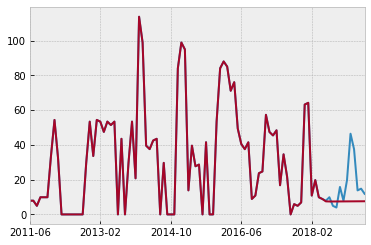

In [ ]:
X_sample, y_sample = X_train.iloc[100], y_train.iloc[100]

pd.concat([X_sample, y_sample]).plot()
pd.concat([X_sample, y_pred]).plot()
plt.show()

In [ ]:
def pred_ARIMA(row):
    model = ARIMA(row, order = (0, 1, 1))
    model_fit = model.fit(trend = 'c', disp = False)
    return model_fit.forecast(steps = 12)[0]

In [ ]:
def model_ARIMA(df):
    result = pd.DataFrame(
        data = map(pred_ARIMA, df.values),
        columns = sample_submission.columns,
        index = df.index
    )
    return result

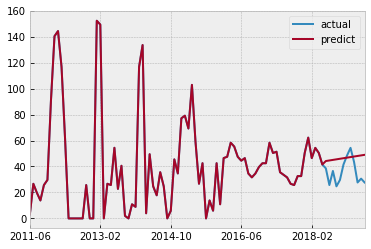

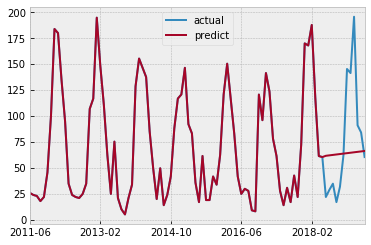

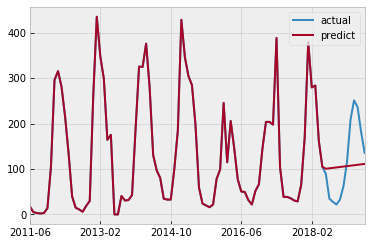

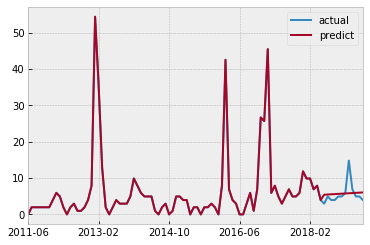

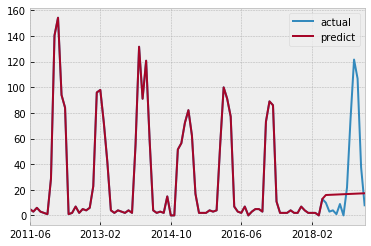

In [ ]:
for i in range(12345, 12350):

    y_pred = model_ARIMA(X_train.iloc[i: i+1])
    X_sample, y_sample = X_train.iloc[i], y_train.iloc[i]

    pd.concat([X_sample, y_sample]).plot()
    pd.concat([X_sample, y_pred.iloc[0]]).plot()
    plt.legend(['actual', 'predict'])
    plt.show()

In [ ]:
pred = model_ARIMA(test)

In [ ]:
sample_submission = pd.DataFrame(data = pred, columns = sample_submission.columns, index = sample_submission.index)
sample_submission.to_csv('submissions/submission_ARIMA.csv')

### 2. SARIMAX

- Seasonal ARIMA eXogenous의 약자입니다.
- 위의 ARIMA는 계절성을 반영하기 힘들기 때문에 보완된 모델입니다.
- AIC가 평균적으로 가장 작도록하는 parameter를 구하여 사용하였습니다.

In [ ]:
model = SARIMAX(X_train.iloc[0].values, order = (1, 0, 0), seasonal_order = (0, 1, 1, 12))
fitted = model.fit(disp = False)
fitted.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  108
Model:             SARIMAX(1, 0, 0)x(0, 1, 1, 12)   Log Likelihood                -389.201
Date:                            Wed, 22 Apr 2020   AIC                            784.402
Time:                                    11:13:51   BIC                            792.095
Sample:                                         0   HQIC                           787.511
                                            - 108                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1909      0.094      2.034      0.042       0.007       0.375
ma.S.L12      -0.7118      0.087     -8.152      0.000      -0.883      -0.541
sigma2       178.0682     24.752      7.194      0.000     129.555     226.581
===================================================================================
Ljung-Box (Q):                       30.93   Jarque-Bera (JB):                 3.49
Prob(Q):                              0.85   Prob(JB):                         0.17
Heteroskedasticity (H):               3.20   Skew:                             0.14
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.89
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

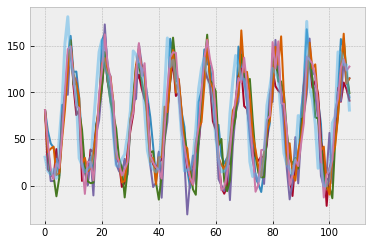

In [ ]:
np.random.seed(0)
for i in range(6):
    plt.plot(fitted.simulate(len(X_train.iloc[0].values), initial_state = fitted.filtered_state[:, -1]))
plt.plot(X_train.iloc[0].values, lw=3, alpha=0.5)
plt.show()

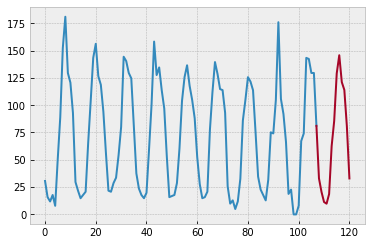

In [ ]:
horizon = 12
pred = fitted.get_prediction(start=len(X_train.iloc[0].values), end=len(X_train.iloc[0].values) + horizon)
s = X_train.iloc[0].values.copy()
s[:-1] = np.nan
s = np.hstack([s, pred.predicted_mean])
ci = pred.conf_int(alpha = 0.05)

plt.plot(X_train.iloc[0].values)
plt.plot(s)
plt.show()

In [ ]:
def pred_SARIMAX(row):
    model = SARIMAX(row,  order = (1, 0, 0), seasonal_order = (0, 1, 1, 12), enforce_invertibility = False)
    model_fit = model.fit(disp = False)
    return model_fit.forecast(12, alpha = .05)

In [ ]:
def model_SARIMAX(df):
    result = pd.DataFrame(
        data = map(pred_SARIMAX, df.values),
        columns = sample_submission.columns,
        index = df.index
    )
    return result

In [ ]:
pred = model_SARIMAX(test)

In [ ]:
sample_submission = pd.DataFrame(data = pred, columns = sample_submission.columns, index = sample_submission.index)
sample_submission.to_csv('submissions/submission_SARIMAX.csv')

### 3. Prophet

- 공부가 더 필요한 모델입니다.
- 시간이 너무 오래 걸려 예측을 중단하였습니다.

In [ ]:
model = Prophet(changepoint_prior_scale = 0.5, 
                changepoint_range = 0.99,
                weekly_seasonality = False,
                daily_seasonality = False)
model.add_seasonality(name = 'monthly', period = 12, fourier_order = 12, prior_scale = 0.1)

In [ ]:
model.fit(
    X_train.iloc[0].to_frame().reset_index().rename(columns = {'index': 'ds', X_train.iloc[0].name : 'y'})
)

In [ ]:
future = model.make_future_dataframe(periods = 12, freq = 'M')

In [ ]:
pred = model.predict(future)

In [ ]:
y_pred = pred.iloc[-12:].yhat.values
y_true = y_train.iloc[0]

In [ ]:
np.sqrt(np.mean(np.square(y_pred - y_true)))

20.866637425138887

In [ ]:
def model_prophet(df):
    result = list()
    total = tqdm_notebook(range(df.shape[0]))
    for i in total:
        model = Prophet(changepoint_prior_scale = 0.5, 
                        changepoint_range = 0.99,
                        weekly_seasonality = False,
                        daily_seasonality = False)
        model.add_seasonality(name = 'monthly', period = 12, fourier_order = 12, prior_scale = 0.1)
        model.fit(
            X_train.iloc[0].to_frame().reset_index().rename(columns = {'index': 'ds', X_train.iloc[0].name : 'y'})
        )
        future = model.make_future_dataframe(periods = 12, freq = 'M')
        pred = model.predict(future).iloc[-12:].yhat.values
        result.append(pred)
    return result

In [ ]:
model_prophet(X_test)

KeyboardInterrupt: 

### 4. MLP

- 간단한 Multi-Layered Perceptron 입니다.
- 주로 keras의 MLP를 사용해왔지만 이번엔 sklearn의 MLP를 사용해보았습니다.
- layer를 더 쌓아도 크게 개선될 여지가 없었습니다.

In [ ]:
model = MLPRegressor(
    hidden_layer_sizes = [36, 16, 12],
    max_iter = 100,
    alpha = 0.001,
    random_state = 777,
    early_stopping = True, 
    verbose = 2
)

In [ ]:
model.fit(X_train, y_train)

Iteration 1, loss = 607.37020248
Validation score: 0.571638
Iteration 2, loss = 364.98560816
Validation score: 0.594236
Iteration 3, loss = 352.32495701
Validation score: 0.602944
Iteration 4, loss = 345.89746371
Validation score: 0.610433
Iteration 5, loss = 342.11697541
Validation score: 0.612304
Iteration 6, loss = 339.39910429
Validation score: 0.609687
Iteration 7, loss = 338.90404548
Validation score: 0.614062
Iteration 8, loss = 337.08021810
Validation score: 0.615051
Iteration 9, loss = 336.65283367
Validation score: 0.617304
Iteration 10, loss = 336.62022396
Validation score: 0.615411
Iteration 11, loss = 335.82800990
Validation score: 0.618293
Iteration 12, loss = 335.92094199
Validation score: 0.616334
Iteration 13, loss = 335.60076648
Validation score: 0.619475
Iteration 14, loss = 334.74164192
Validation score: 0.616697
Iteration 15, loss = 335.45336518
Validation score: 0.618375
Iteration 16, loss = 334.74746738
Validation score: 0.617446
Iteration 17, loss = 334.37796626

MLPRegressor(activation='relu', alpha=0.001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=True, epsilon=1e-08,
       hidden_layer_sizes=[36, 16, 12], learning_rate='constant',
       learning_rate_init=0.001, max_iter=100, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=777, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=2, warm_start=False)

In [ ]:
y_pred = model.predict(X_train)
y_true = y_train.values

In [ ]:
np.mean(np.sqrt(np.mean(np.square(y_true - y_pred), axis = 0)))

22.77467122432238

In [ ]:
validation = pd.DataFrame(data = y_pred, columns = sample_submission.columns, index = train.index)
validation.to_csv('submissions/validation_MLP.csv')

In [ ]:
pred = model.predict(X_test)
sample_submission = pd.DataFrame(data = pred, columns = sample_submission.columns, index = sample_submission.index)
sample_submission.to_csv('submissions/submission_MLP.csv')